In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

2023-01-30 12:42:20.332329: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
sensors = ['accX', 'accY', 'accZ', 'wx', 'wy',
                        'wz', 'bx', 'by', 'bz']

In [6]:
_raw_df = pd.DataFrame([0]*len(sensors)).transpose()
_raw_df.columns = sensors
_raw_df

,accX,accY,accZ,wx,wy,wz,bx,by,bz
0,0,0,0,0,0,0,0,0,0


In [7]:
def readings():
    return 1, 2, 3, 4, 5, 6, 7, 8, 9

In [9]:
accX, accY, accZ, wx, wy, wz, bx, by, bz = readings()

col_dict = {
    'accX': accX, 'accY': accY, 'accZ': accZ, 'wx': wx,
    'wy': wy, 'wz': wz, 'bx': bx, 'by': by, 'bz': bz
}

_raw_df = pd.concat([_raw_df, pd.DataFrame(
    [col_dict.values()], columns=sensors)], axis=0, ignore_index=True)

_raw_df

,accX,accY,accZ,wx,wy,wz,bx,by,bz
0,0,0,0,0,0,0,0,0,0
1,1,2,3,4,5,6,7,8,9
2,1,2,3,4,5,6,7,8,9


In [10]:
_raw_df = _raw_df.tail(-1)
_raw_df

,accX,accY,accZ,wx,wy,wz,bx,by,bz
1,1,2,3,4,5,6,7,8,9
2,1,2,3,4,5,6,7,8,9


In [44]:
test_df = pd.read_csv('../data/OL50_10secframe_Proccessed_Test_Xy_Matrix.csv')
y_true = test_df['Activity']

In [45]:
remove_isens = ['Isens_min', 'Isens_max', 'Isens_mean', 'Isens_kurt', 'Isens_sem',
                'Isens_std', 'Isens_var', 'Isens_skew', 'Isens_mad', 'Isens_sum']

remove_srms = ['Srms_min', 'Srms_max', 'Srms_mean', 'Srms_kurt', 'Srms_sem',
              'Srms_std', 'Srms_var', 'Srms_skew', 'Srms_mad', 'Srms_sum']

remove_unnamed = ['Unnamed: 0', 'Activity', 'Subject Number', 'Trial']

In [46]:
test_df = test_df.drop(remove_isens + remove_srms + remove_unnamed, axis=1)

In [47]:
test_df.shape

(3240, 90)

In [26]:
y_pred = np.empty((len(test_df),))
y_pred.shape

(3240,)

In [34]:
def plot_cf(y_true, y_pred, title_suffix):
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    ax.set_title('Confusion Matrix' + title_suffix)
    ax.set_xlabel('Predicted Activity')
    ax.set_ylabel('True Activity')
    ax.legend([])
    plt.show()

def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    return cm.diagonal()

In [41]:
num_sensors = 9
num_features = 10

tflite_model = '../pi-scripts/model.tflite'

interpreter = tf.lite.Interpreter(tflite_model)
interpreter.allocate_tensors()

output_intp = interpreter.get_output_details()[0]
input_intp = interpreter.get_input_details()[0]

y_pred_f32 = np.empty((len(test_df),))


In [56]:
start_time = time.perf_counter()
for i, row in test_df.iterrows():
  # tensor = row
  print(row[:])
  break
  tensor = tf.cast(tensor, tf.float32)
  tensor = tf.reshape(tensor, (1,9,10))
  interpreter.set_tensor(input_intp['index'], tensor)
  interpreter.invoke()
  y_pred_f32[i] = np.argmax(interpreter.get_tensor(output_intp['index']), axis=1)

end_time = time.perf_counter()
print(f"Model Inference Time for N={len(test_df)} inferences: {(end_time-start_time)*1000}ms")

accX_min        -0.148193
accX_max         0.802612
accX_mean        0.365785
accX_kurt       -0.017930
accX_sem         0.005143
                 ...     
bz_std           3.887982
bz_var          15.116400
bz_skew         -1.429495
bz_mad           2.477308
bz_sum       16747.619629
Name: 0, Length: 90, dtype: float64
Model Inference Time for N=3240 inferences: 1.9111749988951487ms


[2. 2. 2. ... 2. 2. 2.]


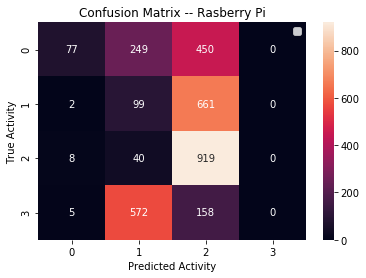

Accuracy of Float32 Model: [0.0992268  0.12992126 0.95036194 0.        ]


In [51]:
plot_cf(y_true, y_pred_f32, ' -- Rasberry Pi')
print(f"Accuracy of Float32 Model: {accuracy(y_true, y_pred_f32)}")

In [60]:
import os
# ROOT_DIR = os.path.dirname(__file__)
__file__


NameError: name '__file__' is not defined